In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.tail(12)

,Sentence #,Word,Tag
1048563,Sentence: 47958,exploded,O
1048564,Sentence: 47958,upon,O
1048565,Sentence: 47958,impact,O
1048566,Sentence: 47958,.,O
1048567,Sentence: 47959,Indian,B-gpe
1048568,Sentence: 47959,forces,O
1048569,Sentence: 47959,said,O
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O


In [2]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35179

In [3]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

In [4]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [5]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [27]:
sentences = getter.sentences
print(len(sentences))

47959


In [7]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


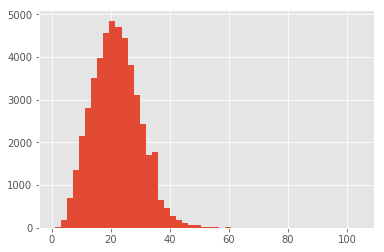

In [8]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [9]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['B-geo'])

1745
10


In [10]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [11]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

Using TensorFlow backend.


array([4, 7, 7, 0, 1, 1, 1, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7])

In [12]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)


In [13]:
batch_size = 32
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)

In [14]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

INFO:tensorflow:Using C:\Users\WHTIGE~1\AppData\Local\Temp\tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/aggregation/scaling:0 from checkpoint b'C:\\Users\\WHTIGE~1\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with aggregation/scaling
INFO:tensorflow:Initialize variable module/aggregation/weights:0 from checkpoint b'C:\\Users\\WHTIGE~1\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with aggregation/weights
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_0:0 from checkpoint b'C:\\Users\\WHTIGE~1\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/CNN/W_cnn_0
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_1:0 from checkpoint b'C:\\Users\\WHTIGE~1\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/CNN/W_cnn_1
I

INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'C:\\Users\\WHTIGE~1\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel
INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'C:\\Users\\WHTIGE~1\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel
INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'C:\\Users\\WHTIGE~1\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias
INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/l

In [15]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [16]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [17]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [18]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [19]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [20]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=3, verbose=1)

Train on 38816 samples, validate on 4320 samples
Epoch 1/3
38816/38816 [==============================] - 834s 21ms/step - loss: 0.0625 - acc: 0.9818 - val_loss: 0.0449 - val_acc: 0.9861
Epoch 2/3
38816/38816 [==============================] - 833s 21ms/step - loss: 0.0405 - acc: 0.9869 - val_loss: 0.0417 - val_acc: 0.9868
Epoch 3/3
38816/38816 [==============================] - 831s 21ms/step - loss: 0.0336 - acc: 0.9886 - val_loss: 0.0406 - val_acc: 0.9873


In [28]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

4768/4768 [==============================] - 64s 13ms/step


In [49]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])


In [50]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 82.4%


In [51]:
print(classification_report(test_labels, pred_labels))

             precision    recall  f1-score   support

        org       0.69      0.66      0.68      2061
        tim       0.88      0.84      0.86      2148
        gpe       0.95      0.93      0.94      1591
        per       0.75      0.80      0.77      1677
        geo       0.85      0.89      0.87      3720
        art       0.23      0.14      0.18        49
        eve       0.33      0.33      0.33        33
        nat       0.47      0.36      0.41        22

avg / total       0.82      0.82      0.82     11301



In [1]:
i = 390
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

NameError: name 'model' is not defined